In [1]:
import cupy as cp
import numpy as np
import librosa as lb
import soundfile as sf
import matplotlib.pyplot as plt

import os, time

from src.core.lstm import BiLSTM
from src.core.layers import Linear, SigmoidActivation
from src.core.loss import MSELoss
from src.core.optimizers import Adam
from src.core.cosine_scheduler import CosineScheduler
from src.projects.noise_reduction.fourier_transform import compute_stft_vectorized, compute_stft_inv, convert_to_db, filter_downsample, plot_spectrogram
from src.utils.save_and_load_model import save_model, load_model
from src.utils.save_and_load_checkpoint import save_checkpoint, load_checkpoint

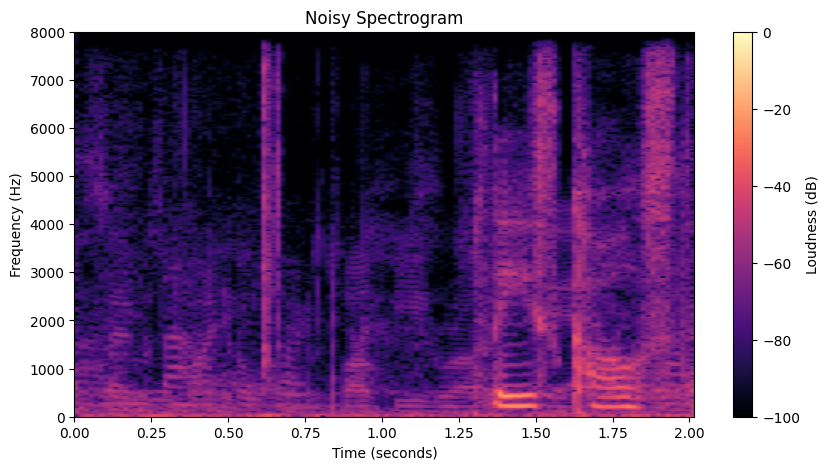

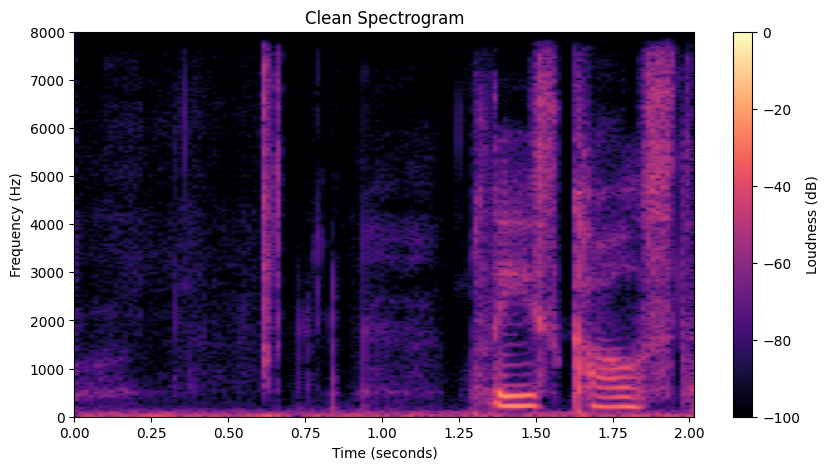

In [2]:
noisy_path = r"C:\Datasets\Clean and Noisy Audio Dataset 16kHz NumPy Spectrogram Magnitudes\train\noisy\p234_001.npy"
clean_path = r"C:\Datasets\Clean and Noisy Audio Dataset 16kHz NumPy Spectrogram Magnitudes\train\clean\p234_001.npy"

# We already preprocessed the audios to 16kHz
sr, N, hop = 16000, 512, 256

n_spec = cp.load(noisy_path)
c_spec = cp.load(clean_path)

plot_spectrogram(n_spec, sr, hop, N, title='Noisy Spectrogram', is_raw_magnitude=True)
plot_spectrogram(c_spec, sr, hop, N, title='Clean Spectrogram', is_raw_magnitude=True)

In [3]:
# Our idea for training the model: We have our audio. We turn it into a spectrogram, of shape (B, num_frames, bins)
# We feed the LSTM just cp.abs(spectrogram) scaled to decibels
# We store the magnitude and the phase. We need it to reconstruct it later.
# LSTM masks the magnitudes, then we just do clean_magnitude * cp.exp(1j * phase) to correctly scale and rotate back to complex plane.
# Then we convert new spectrogram back to audio

# Basically: Input a spectrogram, output a mask. 

# Pipeline is: BiLSTM -> Linear -> Sigmoid -> MSELoss(pred, real mask)

# We train on only 2s chunks. We can infer on 60s tho - if we chopped it up, the bidirectional LSTM wouldnt really look into the future - it would be lobotomised every say, 2s of audio being cleaned.
# Also the memory probably wont run out, because we dont do backward pass.

In [4]:
class VoiceDataset:
    def __init__(self, path, duration, sr, N, hop, batch_size):
        self.duration = duration
        self.sr = sr
        self.N = N
        self.hop = hop
        self.batch_size = batch_size
        
        self.train_split = []
        self.test_split = []
        
        self.num_batches = {
            "train" : None,
            "test" : None
        }
        
        for split in ['train', 'test']:
            clean_dir_path = os.path.join(path, split, 'clean')
            noisy_dir_path = os.path.join(path, split, 'noisy')
            
            # We know the names are the same in both directories, same amount of files
            clean_files = sorted(os.listdir(clean_dir_path))
            noisy_files = sorted(os.listdir(noisy_dir_path))
            
            self.num_batches[split] = len(clean_files) // batch_size
            
            for batch_index in range(self.num_batches[split]):
                start = batch_index * batch_size
                end = start + batch_size
                
                batch_paths = []
                for i in range(start, end):
                    c_path = os.path.join(clean_dir_path, clean_files[i])
                    n_path = os.path.join(noisy_dir_path, noisy_files[i])
                    
                    batch_paths.append((c_path, n_path))
                    
                if split == "train":
                    self.train_split.append(batch_paths)
                elif split == 'test':
                    self.test_split.append(batch_paths)
                    
    def get_batch(self, split='train', index=0):
        if split == 'train':
            batch_list = self.train_split[index]
        elif split == 'test':
            batch_list = self.test_split[index]
            
        X_batch, Y_batch = [], []
            
        
        for clean_path, noisy_path in batch_list:
            c_mag = cp.load(clean_path, mmap_mode='r') # mmap_mode grants big memory efficiency boost (didn't know that)
            n_mag = cp.load(noisy_path, mmap_mode='r')
            
            x_input = convert_to_db(n_spec, self.N, is_raw_magnitude=True)
            
            mask = c_mag / (n_mag + 1e-9) # target_mask = cp.abs(clean) / cp.abs(noisy) -> this means "how much of clean signal is in the noisy?" If its 100% then its 1, if 0% then 0.
            mask = cp.clip(mask, 0, 1, mask)
            
            X_batch.append(x_input)
            Y_batch.append(mask)
            
        return cp.stack(X_batch), cp.stack(Y_batch)

In [5]:
dataset_path = r"C:\Datasets\Clean and Noisy Audio Dataset 16kHz NumPy Spectrogram Magnitudes"
duration = 2 # 2 sec per sample, if less we pad
sampling_rate = 16000
N, hop = 512, 256
batch_size = 128

input_dim = N // 2 + 1 # amount of bins
hidden_dim = 512
output_dim = N // 2 + 1 # also amount of bins (the mask)

max_lr = 5e-4
min_lr = 1e-5
warmup_epochs = 5
total_epochs = 20

dataset = VoiceDataset(dataset_path, sampling_rate, duration, N, hop, batch_size)
model = BiLSTM(input_dim, hidden_dim, output_dim)
head = Linear(2 * hidden_dim, output_dim) # 2 x hidden because its Bidirectional LSTM
head_act = SigmoidActivation()
loss_fn = MSELoss()
params = model.params() + head.params()
optimizer = Adam(params, max_lr, beta1=0.9, beta2=0.999, eps=1e-8)
scheduler = CosineScheduler(max_lr, min_lr, warmup_epochs, total_epochs)

learnable_layers = {
    "BiLSTM" : model,
    "Head" : head
}

In [ ]:
checkpoint_path = 'models/best_denoise.npz'
resume_training = False

start_epoch = 1
best_loss = float('inf')
if resume_training:
    start_epoch, best_loss = load_checkpoint(checkpoint_path, learnable_layers, optimizer)
    
train_loss_history = []
test_loss_history = []

for epoch in range(start_epoch, total_epochs+1):
    learning_rate = scheduler.get_lr(epoch)
    
    epoch_train_losses = []
    epoch_test_losses = []
    
    # Train
    for batch_index in range(dataset.num_batches['train']):
        start_time = time.time()
        
        X_batch, Y_batch = dataset.get_batch('train', batch_index)

        hidden_states = model.forward(X_batch, init_f_states=None, init_b_states=None) # (B, num_frames, 2 * hidden_dim)
        logits = head.forward(hidden_states) # (B, num_frames, output_dim)
        mask = head_act.forward(logits)
        loss = loss_fn.forward(mask, Y_batch) 
        
        epoch_train_losses.append(loss.get())
        
        dmask = loss_fn.backward()
        dlogits = head_act.backward(dmask)
        dhidden_states = head.backward(dlogits)
        dinput = model.backward(dhidden_states)
        
        optimizer.step(learning_rate)
        
        end_time = time.time()
        diff = end_time - start_time
        
        if batch_index % 10 == 0:
            total_steps = total_epochs * dataset.num_batches['train']
            completed_steps = ((epoch - 1) * dataset.num_batches['train']) + (batch_index + 1) 
            progress = completed_steps / total_steps * 100
            print(f"Epoch: {epoch} | Batch: {batch_index+1} | Loss: {np.mean(epoch_train_losses):.8f} | BPM: {60 / diff:.2f} batches | Progress: {progress:.2f}%")
    
    # Eval
    for batch_index in range(dataset.num_batches['test']):
        start_time = time.time()
        
        X_batch, Y_batch = dataset.get_batch('test', batch_index)

        hidden_states = model.forward(X_batch, init_f_states=None, init_b_states=None) # (B, num_frames, 2 * hidden_dim)
        logits = head.forward(hidden_states) # (B, num_frames, output_dim)
        mask = head_act.forward(logits)
        loss = loss_fn.forward(mask, Y_batch) 
        
        epoch_test_losses.append(loss.get())
    
    ave_train_loss = np.mean(epoch_train_losses)
    ave_test_loss = np.mean(epoch_test_losses)
    
    train_loss_history.append(ave_train_loss) # already Numpy
    test_loss_history.append(ave_test_loss) # same
    
    print(f"Finished epoch {epoch}. Training Loss: {np.mean(ave_train_loss):.8f} Test Loss: {np.mean(ave_test_loss):.8f}")
    
    if ave_train_loss < best_loss:
        best_loss = ave_train_loss
        save_checkpoint(checkpoint_path, learnable_layers, optimizer, epoch, best_loss) 

ffw
linear
Epoch: 1 | Batch: 1 | Loss: 0.39265795 | BPM: 23.72 batches | Progress: 0.05%
ffw
linear
Epoch: 1 | Batch: 2 | Loss: 0.38883506 | BPM: 35.93 batches | Progress: 0.05%
ffw
linear
Epoch: 1 | Batch: 3 | Loss: 0.38661861 | BPM: 35.49 batches | Progress: 0.05%
ffw
linear
Epoch: 1 | Batch: 4 | Loss: 0.38692625 | BPM: 35.94 batches | Progress: 0.05%
ffw
linear
Epoch: 1 | Batch: 5 | Loss: 0.38650958 | BPM: 35.71 batches | Progress: 0.05%
ffw
linear
Epoch: 1 | Batch: 6 | Loss: 0.38546079 | BPM: 35.65 batches | Progress: 0.05%
ffw
linear
Epoch: 1 | Batch: 7 | Loss: 0.38375403 | BPM: 35.27 batches | Progress: 0.05%
ffw
linear
Epoch: 1 | Batch: 8 | Loss: 0.38242286 | BPM: 35.59 batches | Progress: 0.05%
ffw
linear
Epoch: 1 | Batch: 9 | Loss: 0.38216864 | BPM: 35.00 batches | Progress: 0.05%
ffw
linear
Epoch: 1 | Batch: 10 | Loss: 0.38211643 | BPM: 14.01 batches | Progress: 0.05%
ffw
linear
Epoch: 1 | Batch: 11 | Loss: 0.38186379 | BPM: 14.42 batches | Progress: 0.05%
ffw


KeyboardInterrupt: 

In [ ]:
def clean_recording(path: str, sr: int, N: int, hop: int, model: BiLSTM, head: Linear, head_act: SigmoidActivation):
    audio, _ = lb.load(path, sr=sr) # SR must always be 16kHz for our model
    
    spec, orig_len = compute_stft_vectorized(audio, N, hop) # (num_frames, K), we need orig_len to reverse the padding
    mag = convert_to_db(spec) # (num_frames, K)
    
    mag = mag[cp.newaxis, :, :]
    
    h = model.forward(mag)
    logits = head.forward(h)
    mask = head_act.forward(logits).squeeze() # remove the single dim at the start (B=1) 
    
    cleaned_spec = spec * mask # scales imaginary and real components accordingly
    audio = compute_stft_inv(cleaned_spec, orig_len, N, hop)
    
    return audio

In [ ]:
best_model_path = "models/best_denoise.npz"
load_model(best_model_path, learnable_layers)

noisy_audio_path = r"noisy_sample.wav"
output_audio_path = r"clean_sample.wav"

clean_audio = clean_recording(noisy_audio_path, sampling_rate, N, hop, model, head, head_act)

sf.write(output_audio_path, clean_audio, sampling_rate)